# <span style="color: darkblue; font-weight: bold; font-size: 30px;">Football Match Prediction Using Machine Learning</span> 


# <span style="color: blue; font-weight: bold;">1. Data Preparation</span>
In this step, we load the dataset, inspect its structure, and prepare it for further analysis.

In [1]:
import pandas as pd

# Load the dataset
file_name = "sff_somaliFootball_historical_data.csv"
df = pd.read_csv(file_name)

# Clean the date column (remove leading/trailing spaces)
df["date"] = df["date"].str.strip()

# Convert date to datetime format
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y", errors="coerce")

# Sort the dataset by date (ascending order)
df = df.sort_values(by="date")

# Extract Home_Score and Away_Score
df[["Home_Score", "Away_Score"]] = df["score"].str.split(" : ", expand=True).astype(int)

# Calculate Home_Goal_Diff and Away_Goal_Diff
df["Home_Goal_Diff"] = df["Home_Score"] - df["Away_Score"]
df["Away_Goal_Diff"] = df["Away_Score"] - df["Home_Score"]

# Determine Result
df["Result"] = df["Home_Goal_Diff"].apply(lambda x: "Win" if x > 0 else "Loss" if x < 0 else "Draw")

# Extract Season from date
df["Season"] = df["date"].dt.year

# Initialize new features
df["Home_Last_5_Wins"] = 0
df["Away_Last_5_Wins"] = 0
df["H2H_Home_Wins"] = 0
df["H2H_Home_Losses"] = 0
df["H2H_Away_Wins"] = 0
df["H2H_Away_Losses"] = 0
df["H2H_Draws"] = 0

# Function to calculate last 5 wins for a team
def calculate_last_5_wins(team, current_date):
    matches = df[(df["date"] < current_date) & 
                 ((df["home"] == team) | (df["away"] == team))]
    last_5_matches = matches.tail(5)
    wins = len(last_5_matches[((last_5_matches["home"] == team) & (last_5_matches["Result"] == "Win")) | 
                              ((last_5_matches["away"] == team) & (last_5_matches["Result"] == "Loss"))])
    return wins

# Function to calculate H2H stats
def calculate_h2h_stats(home_team, away_team, current_date):
    past_matches = df[(df["date"] < current_date) & 
                      (((df["home"] == home_team) & (df["away"] == away_team)) | 
                       ((df["home"] == away_team) & (df["away"] == home_team)))]

    home_wins = len(past_matches[(past_matches["home"] == home_team) & (past_matches["Result"] == "Win")])
    away_wins = len(past_matches[(past_matches["home"] == away_team) & (past_matches["Result"] == "Win")])
    draws = len(past_matches[past_matches["Result"] == "Draw"])

    return home_wins, away_wins, draws

# Calculate features for each row
for i, row in df.iterrows():
    home_team = row["home"]
    away_team = row["away"]
    current_date = row["date"]

    # Last 5 Wins
    df.at[i, "Home_Last_5_Wins"] = calculate_last_5_wins(home_team, current_date)
    df.at[i, "Away_Last_5_Wins"] = calculate_last_5_wins(away_team, current_date)

    # H2H Stats
    home_wins, away_wins, draws = calculate_h2h_stats(home_team, away_team, current_date)
    
    df.at[i, "H2H_Home_Wins"] = home_wins
    df.at[i, "H2H_Away_Wins"] = away_wins
    df.at[i, "H2H_Draws"] = draws
    df.at[i, "H2H_Home_Losses"] = away_wins  # Home team's losses are away team's wins
    df.at[i, "H2H_Away_Losses"] = home_wins  # Away team's losses are home team's wins

# Select and reorder columns
new_columns = [
    "Season", "date", "home", "away", "Home_Score", "Away_Score", 
    "Home_Goal_Diff", "Away_Goal_Diff", "Result", 
    "Home_Last_5_Wins", "Away_Last_5_Wins",
    "H2H_Home_Wins", "H2H_Home_Losses", "H2H_Away_Wins", "H2H_Away_Losses", "H2H_Draws"
]
df = df[new_columns]

# Rename columns for clarity
df.columns = [
    "Season", "Date", "Home_Team", "Away_Team", "Home_Score", "Away_Score", 
    "Home_Goal_Diff", "Away_Goal_Diff", "Result", 
    "Home_Last_5_Wins", "Away_Last_5_Wins",
    "H2H_Home_Wins", "H2H_Home_Losses", "H2H_Away_Wins", "H2H_Away_Losses", "H2H_Draws"
]

# Save to new CSV file
output_file_name = "Somali_league_datasets.csv"
df.to_csv(output_file_name, index=False)

print("Transformation complete! File saved as:", output_file_name)
print(df.head())  # Preview the transformed dataset


Transformation complete! File saved as: Somali_league_datasets.csv
   Season       Date              Home_Team      Away_Team  Home_Score  \
0    2012 2012-06-04              Elman FC    Badbaado FC            3   
1    2012 2012-06-05             Sahafi FC     Jeenyo  FC            1   
2    2012 2012-06-07            Heegan S.C     Dekedda SC            1   
3    2012 2012-06-08   Mogadishu City Club    Horseed S.C            1   
4    2012 2012-06-11            Jeenyo  FC       Elman FC            1   

   Away_Score  Home_Goal_Diff  Away_Goal_Diff Result  Home_Last_5_Wins  \
0           1               2              -2    Win                 0   
1           1               0               0   Draw                 0   
2           1               0               0   Draw                 0   
3           1               0               0   Draw                 0   
4           1               0               0   Draw                 0   

   Away_Last_5_Wins  H2H_Home_Wins  H2H_Hom

# <span style="color: green; font-weight: bold;">2. Data Cleaning</span>
Here, we handle missing values, remove duplicates, and ensure the dataset is clean and ready for modeling.

In [11]:
import pandas as pd

# Step 1: Load the dataset
df = pd.read_csv('Somali_league_datasets.csv')

# Step 2: Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Handle missing values
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:  # Numerical columns
        # Use df[column] = df[column].fillna(df[column].mean()) instead of inplace
        df[column] = df[column].fillna(df[column].mean())
    else:  # Categorical columns
        # Use df[column] = df[column].fillna(df[column].mode()[0]) instead of inplace
        df[column] = df[column].fillna(df[column].mode()[0])

# Step 3: Check for duplicates
print("Number of Duplicates:", df.duplicated().sum())

# Remove duplicates
df.drop_duplicates(inplace=True)

# Step 4: Save the cleaned dataset
df.to_csv('Cleaned_Somali_league_datasets.csv', index=False)

print("Data cleaning completed and saved to 'Cleaned_Somali_league_datasets.csv'.")

Missing Values:
 Season              0
Date                0
Home_Team           0
Away_Team           0
Home_Score          0
Away_Score          0
Home_Goal_Diff      0
Away_Goal_Diff      0
Result              0
Home_Last_5_Wins    0
Away_Last_5_Wins    0
H2H_Home_Wins       0
H2H_Home_Losses     0
H2H_Away_Wins       0
H2H_Away_Losses     0
H2H_Draws           0
dtype: int64
Number of Duplicates: 1
Data cleaning completed and saved to 'Cleaned_Somali_league_datasets.csv'.


# <span style="color: purple; font-weight: bold;">3. Feature Engineering</span>
In this step, we create new features (e.g., team performance metrics) to improve the model's predictive power..

In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Cleaned_Somali_league_datasets.csv")

# Drop the 'Date' column
df = df.drop(columns=["Date"])

# Encode the Result Column
# Ensure all possible values are mapped (e.g., 'Win', 'Draw', 'Loss')
df['Result_Encoded'] = df['Result'].map({'Win': 1, 'Draw': 0, 'Loss': -1})

# Drop the original 'Result' column
df = df.drop(columns=["Result"])

# Drop the existing H2H features
df = df.drop(columns=["H2H_Home_Wins", "H2H_Home_Losses", "H2H_Away_Wins", "H2H_Away_Losses", "H2H_Draws"])

# Function to calculate team form (points and wins in the last 5 matches)
def calculate_form(team_name, team_type, df):
    # Filter matches for the team (home or away)
    if team_type == "Home":
        team_matches = df[df["Home_Team"] == team_name].copy()
        team_matches["Points"] = team_matches["Result_Encoded"].map({1: 3, 0: 1, -1: 0})
        team_matches["Wins"] = (team_matches["Result_Encoded"] == 1).astype(int)  # 1 for win, 0 otherwise
    elif team_type == "Away":
        team_matches = df[df["Away_Team"] == team_name].copy()
        team_matches["Points"] = team_matches["Result_Encoded"].map({1: 0, 0: 1, -1: 3})  # Reverse for away team
        team_matches["Wins"] = (team_matches["Result_Encoded"] == -1).astype(int)  # 1 for win (home loss), 0 otherwise

    # Calculate rolling sum of points and wins for the last 5 matches
    team_matches["Last_5_Points"] = team_matches["Points"].rolling(window=5, min_periods=1).sum()
    team_matches["Last_5_Wins"] = team_matches["Wins"].rolling(window=5, min_periods=1).sum()
    
    # Return the form for the last match (most recent)
    return team_matches["Last_5_Points"].iloc[-1], team_matches["Last_5_Wins"].iloc[-1]

# Function to calculate head-to-head (H2H) statistics
def calculate_h2h(home_team, away_team, df):
    # Filter matches between the two teams
    h2h_matches = df[((df["Home_Team"] == home_team) & (df["Away_Team"] == away_team)) | 
                   ((df["Home_Team"] == away_team) & (df["Away_Team"] == home_team))]
    
    # Calculate H2H wins, losses, and draws for the home team
    h2h_wins_home = h2h_matches[((h2h_matches["Home_Team"] == home_team) & (h2h_matches["Result_Encoded"] == 1)) | 
                                ((h2h_matches["Away_Team"] == home_team) & (h2h_matches["Result_Encoded"] == -1))].shape[0]
    
    h2h_losses_home = h2h_matches[((h2h_matches["Home_Team"] == home_team) & (h2h_matches["Result_Encoded"] == -1)) | 
                      ((h2h_matches["Away_Team"] == home_team) & (h2h_matches["Result_Encoded"] == 1))].shape[0]
    
    # Calculate H2H wins, losses, and draws for the away team
    h2h_wins_away = h2h_matches[((h2h_matches["Home_Team"] == away_team) & (h2h_matches["Result_Encoded"] == 1)) | 
                    ((h2h_matches["Away_Team"] == away_team) & (h2h_matches["Result_Encoded"] == -1))].shape[0]
    
    h2h_losses_away = h2h_matches[((h2h_matches["Home_Team"] == away_team) & (h2h_matches["Result_Encoded"] == -1)) | 
                      ((h2h_matches["Away_Team"] == away_team) & (h2h_matches["Result_Encoded"] == 1))].shape[0]
    
    # Calculate H2H draws
    h2h_draws = h2h_matches[h2h_matches["Result_Encoded"] == 0].shape[0]
    
    return h2h_wins_home, h2h_losses_home, h2h_wins_away, h2h_losses_away, h2h_draws

# Calculate recent form for home and away teams
df["Home_Last_5_Points"], df["Home_Last_5_Wins"] = zip(*df.apply(lambda row: calculate_form(row["Home_Team"], "Home", df), axis=1))
df["Away_Last_5_Points"], df["Away_Last_5_Wins"] = zip(*df.apply(lambda row: calculate_form(row["Away_Team"], "Away", df), axis=1))

# Calculate head-to-head (H2H) statistics
df["H2H_Home_Wins"], df["H2H_Home_Losses"], df["H2H_Away_Wins"], df["H2H_Away_Losses"], df["H2H_Draws"] = zip(*df.apply(lambda row: calculate_h2h(row["Home_Team"], row["Away_Team"], df), axis=1))

# Convert floating-point numbers to integers
df["Home_Last_5_Points"] = df["Home_Last_5_Points"].astype(int)
df["Away_Last_5_Points"] = df["Away_Last_5_Points"].astype(int)
df["Home_Last_5_Wins"] = df["Home_Last_5_Wins"].astype(int)
df["Away_Last_5_Wins"] = df["Away_Last_5_Wins"].astype(int)

# Save the updated dataset
df.to_csv("Prepared7_Somali_Football_Data.csv", index=False)

print("Dataset prepared and saved!")

Dataset prepared and saved!


# <span style="color: green; font-weight: bold;">2. Data Cleaning</span>
Here, we handle missing values, remove duplicates, and ensure the dataset is clean and ready for modeling.

In [8]:
import pandas as pd

# Step 1: Load the dataset
df = pd.read_csv('Prepared7_Somali_Football_Data.csv')

# Step 2: Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Handle missing values
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:  # Numerical columns
        df[column] = df[column].fillna(df[column].mean())
    else:  # Categorical columns
        df[column] = df[column].fillna(df[column].mode()[0])

# Step 3: Check for duplicates
print("Number of Duplicates:", df.duplicated().sum())

# Remove duplicates
df.drop_duplicates(inplace=True)

# Step 4: Clean Home_Team and Away_Team columns
# Remove rows where Home_Team or Away_Team is missing (empty or NaN)
df = df[(df["Home_Team"].notna()) & (df["Away_Team"].notna())]  # Drop rows with NaN
df = df[(df["Home_Team"].str.strip() != "") & (df["Away_Team"].str.strip() != "")]  # Drop rows with empty strings (including hidden spaces)

# Standardize team names (remove extra spaces and ensure consistent naming)
df["Home_Team"] = df["Home_Team"].str.strip()  # Remove leading/trailing spaces
df["Away_Team"] = df["Away_Team"].str.strip()  # Remove leading/trailing spaces
df["Home_Team"] = df["Home_Team"].str.replace(r"\s+", " ", regex=True)  # Replace multiple spaces with a single space
df["Away_Team"] = df["Away_Team"].str.replace(r"\s+", " ", regex=True)  # Replace multiple spaces with a single space

# Ensure consistent naming (example: "Horseed S.C" → "Horseed SC")
df["Home_Team"] = df["Home_Team"].str.replace("S.C", "SC")  # Replace "S.C" with "SC"
df["Away_Team"] = df["Away_Team"].str.replace("S.C", "SC")  # Replace "S.C" with "SC"

# Step 5: Save the cleaned dataset
df.to_csv('Cleaned4_Somali_league_datasets.csv', index=False)

print("Data cleaning completed and saved to 'Cleaned_Somali_league_datasets.csv'.")

Missing Values:
 Season                0
Home_Team             0
Away_Team             0
Home_Score            0
Away_Score            0
Home_Goal_Diff        0
Away_Goal_Diff        0
Home_Last_5_Wins      0
Away_Last_5_Wins      0
Result_Encoded        0
Home_Last_5_Points    0
Away_Last_5_Points    0
H2H_Home_Wins         0
H2H_Home_Losses       0
H2H_Away_Wins         0
H2H_Away_Losses       0
H2H_Draws             0
dtype: int64
Number of Duplicates: 0
Data cleaning completed and saved to 'Cleaned_Somali_league_datasets.csv'.


# <span style="color: orange; font-weight: bold;">4. Splitting the Dataset</span>
We split the dataset into training and testing sets to evaluate the model's performance.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv("Cleaned4_Somali_league_datasets.csv")

# Define features (X) and target (y)
X = df.drop(columns=['Result_Encoded'])
y = df['Result_Encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (673, 16)
Testing set shape: (169, 16)


# <span style="color: red; font-weight: bold;">5. Building Models</span>
In this step, we train multiple machine learning models (e.g., Logistic Regression, Random Forest, XGBoost) on the training data.

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("Cleaned4_Somali_league_datasets.csv")

# Define features and target variable
X = df.drop(columns=["Season", "Home_Team", "Away_Team", "Result_Encoded"])  # Features
y = df["Result_Encoded"]  # Target variable

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
log_reg = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(probability=True)  # Enable probability for precision-recall curve
xgb = XGBClassifier(eval_metric='mlogloss')

# Adjust y_train and y_test for XGBoost
y_train_xgb = y_train + 1
y_test_xgb = y_test + 1

# Train all models and print training messages
print("Training Logistic Regression...")
log_reg.fit(X_train, y_train)
print("Logistic Regression trained!")

print("Training Decision Tree...")
decision_tree.fit(X_train, y_train)
print("Decision Tree trained!")

print("Training Random Forest...")
random_forest.fit(X_train, y_train)
print("Random Forest trained!")

print("Training K-Nearest Neighbors...")
knn.fit(X_train, y_train)
print("K-Nearest Neighbors trained!")

print("Training Support Vector Machine...")
svm.fit(X_train, y_train)
print("Support Vector Machine trained!")

print("Training XGBoost...")
xgb.fit(X_train, y_train_xgb)
print("XGBoost trained!")

Training Logistic Regression...
Logistic Regression trained!
Training Decision Tree...
Decision Tree trained!
Training Random Forest...
Random Forest trained!
Training K-Nearest Neighbors...
K-Nearest Neighbors trained!
Training Support Vector Machine...
Support Vector Machine trained!
Training XGBoost...
XGBoost trained!


# <span style="color: teal; font-weight: bold;">6. Model Evaluation</span>
Here, we evaluate the models using metrics like accuracy, precision, recall, and F1-score to select the best-performing model.

Logistic Regression Accuracy: 1.00
Logistic Regression Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        62
           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        68

    accuracy                           1.00       169
   macro avg       1.00      1.00      1.00       169
weighted avg       1.00      1.00      1.00       169



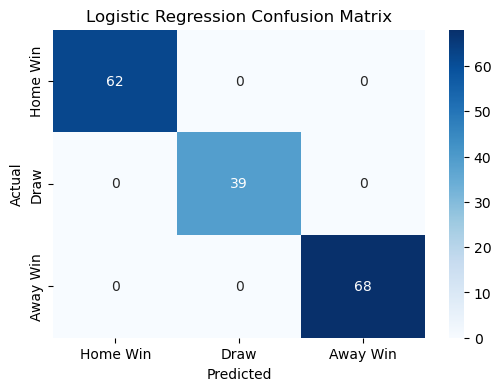

Class 2 has no samples in the test set. Skipping Precision-Recall Curve.


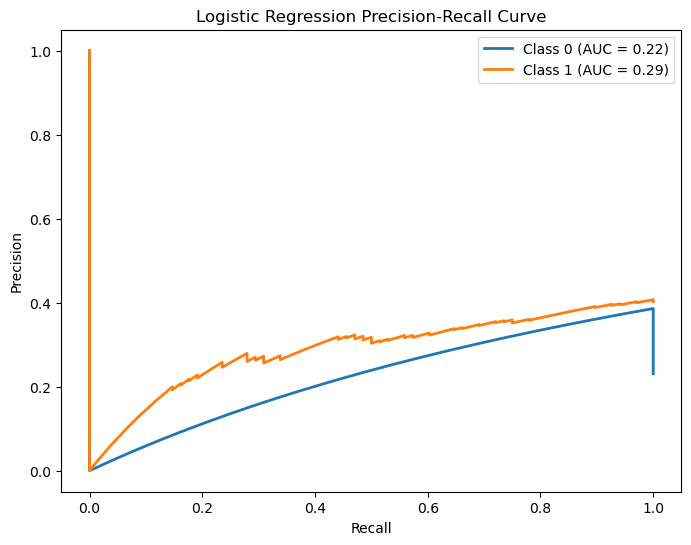

Decision Tree Accuracy: 1.00
Decision Tree Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        62
           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        68

    accuracy                           1.00       169
   macro avg       1.00      1.00      1.00       169
weighted avg       1.00      1.00      1.00       169



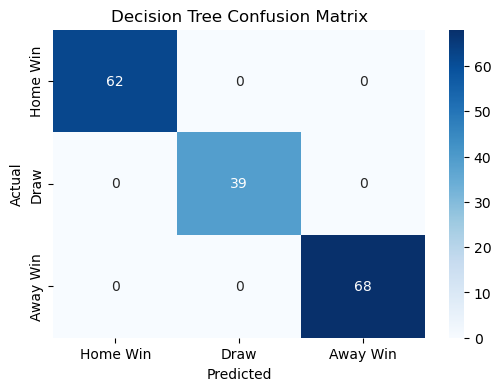

Class 2 has no samples in the test set. Skipping Precision-Recall Curve.


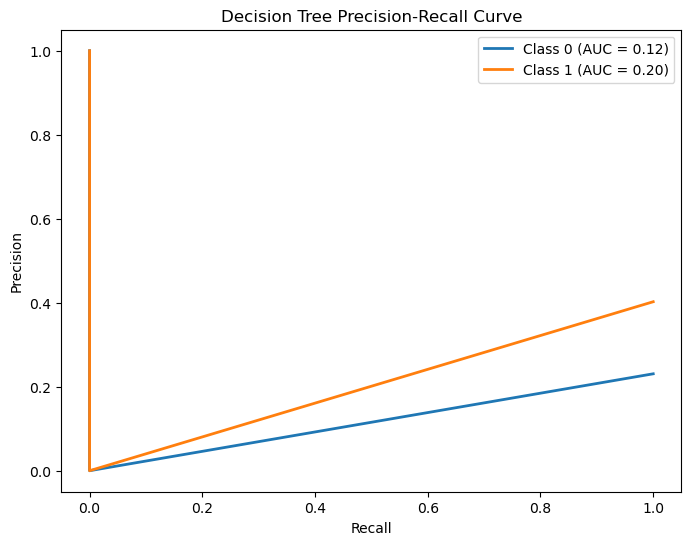

Random Forest Accuracy: 1.00
Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        62
           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        68

    accuracy                           1.00       169
   macro avg       1.00      1.00      1.00       169
weighted avg       1.00      1.00      1.00       169



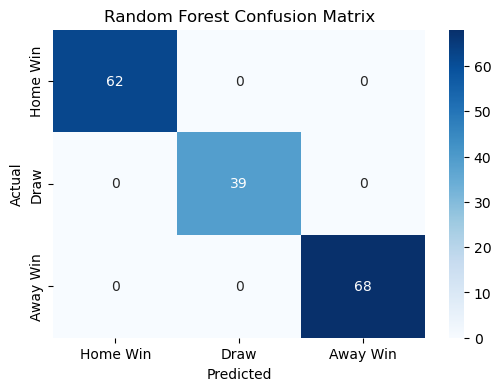

Class 2 has no samples in the test set. Skipping Precision-Recall Curve.


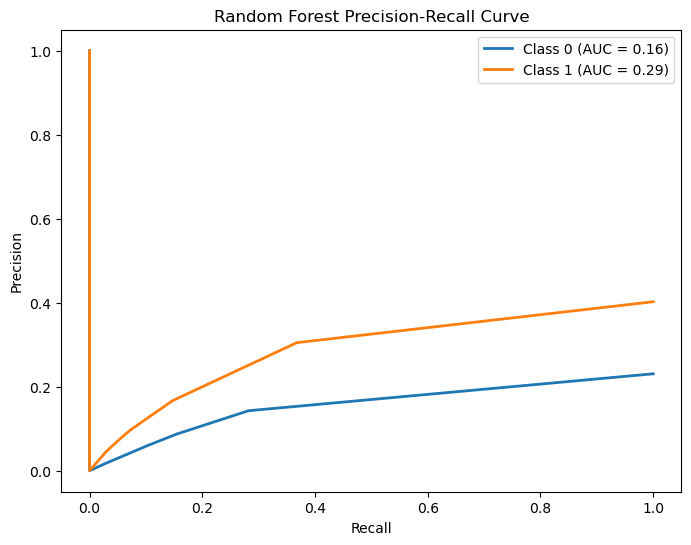

K-Nearest Neighbors Accuracy: 0.83
K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

          -1       0.85      0.94      0.89        62
           0       0.68      0.64      0.66        39
           1       0.89      0.84      0.86        68

    accuracy                           0.83       169
   macro avg       0.81      0.80      0.80       169
weighted avg       0.83      0.83      0.83       169



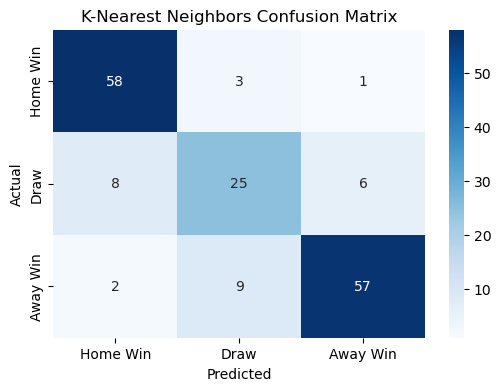

Class 2 has no samples in the test set. Skipping Precision-Recall Curve.


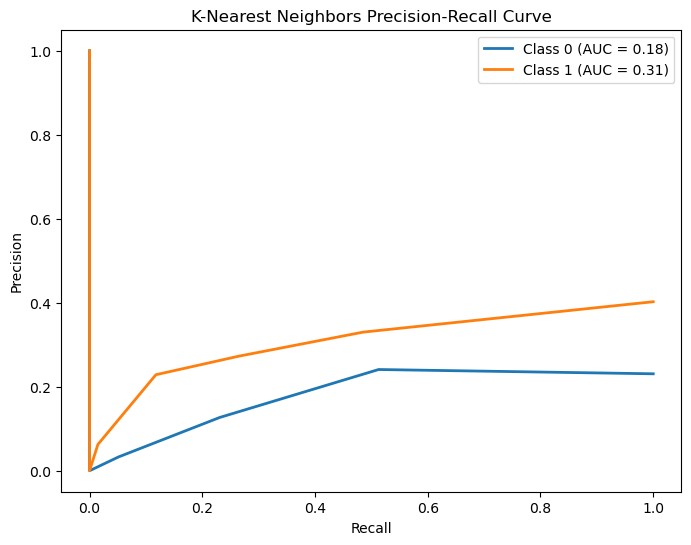

Support Vector Machine Accuracy: 0.98
Support Vector Machine Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.97      0.98        62
           0       0.93      0.97      0.95        39
           1       0.99      0.99      0.99        68

    accuracy                           0.98       169
   macro avg       0.97      0.98      0.97       169
weighted avg       0.98      0.98      0.98       169



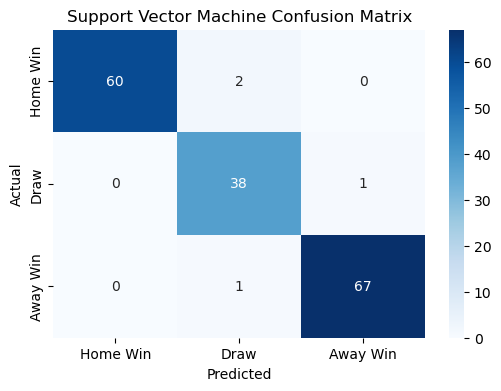

Support Vector Machine does not support predict_proba. Skipping Precision-Recall Curve.
XGBoost Accuracy: 1.00
XGBoost Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        62
           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        68

    accuracy                           1.00       169
   macro avg       1.00      1.00      1.00       169
weighted avg       1.00      1.00      1.00       169



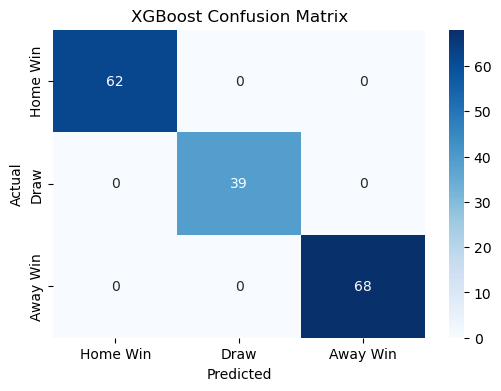

Class 2 has no samples in the test set. Skipping Precision-Recall Curve.


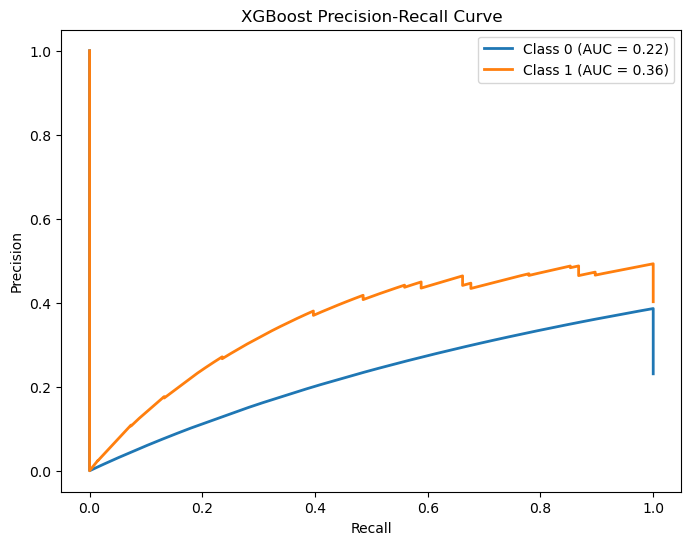

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Function to evaluate a model
def evaluate_model(model, X_test, y_test, model_name, is_xgb=False):
    # Make predictions
    if is_xgb:
        y_pred = model.predict(X_test)
        y_pred = y_pred - 1  # Convert back to original labels for XGBoost
    else:
        y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    
    # Classification report
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Home Win', 'Draw', 'Away Win'], yticklabels=['Home Win', 'Draw', 'Away Win'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    # Precision-Recall Curve (for multi-class, we use One-vs-Rest)
    try:
        y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
        y_pred_proba = model.predict_proba(X_test)
        
        precision = dict()
        recall = dict()
        auc_pr = dict()
        
        for i in range(3):  # 3 classes: Home Win, Draw, Away Win
            if np.sum(y_test_bin[:, i]) > 0:  # Check if the class has at least one sample
                precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
                auc_pr[i] = auc(recall[i], precision[i])
            else:
                print(f"Class {i} has no samples in the test set. Skipping Precision-Recall Curve.")
                continue
        
        plt.figure(figsize=(8, 6))
        for i in range(3):
            if i in precision:  # Only plot if the class has samples
                plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {auc_pr[i]:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{model_name} Precision-Recall Curve')
        plt.legend(loc='best')
        plt.show()
    except AttributeError:
        print(f"{model_name} does not support predict_proba. Skipping Precision-Recall Curve.")

# Evaluate all models
evaluate_model(log_reg, X_test, y_test, "Logistic Regression")
evaluate_model(decision_tree, X_test, y_test, "Decision Tree")
evaluate_model(random_forest, X_test, y_test, "Random Forest")
evaluate_model(knn, X_test, y_test, "K-Nearest Neighbors")
evaluate_model(svm, X_test, y_test, "Support Vector Machine")
evaluate_model(xgb, X_test, y_test, "XGBoost", is_xgb=True)

In [25]:
import pickle

# Save Logistic Regression
with open('logistic_regression.pkl', 'wb') as f:
    pickle.dump(log_reg, f)

# Save Random Forest
with open('random_forest.pkl', 'wb') as f:
    pickle.dump(random_forest, f)

# Save XGBoost
with open('xgboost.pkl', 'wb') as f:
    pickle.dump(xgb, f)

print("Models saved successfully!")

Models saved successfully!


# <span style="color: brown; font-weight: bold;">7. Making Predictions</span>
We use the best model to predict outcomes for new matches and test its performance.

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("Cleaned4_Somali_league_datasets.csv")

# Load the saved models and scaler
with open('logistic_regression.pkl', 'rb') as f:
    log_reg = pickle.load(f)
with open('random_forest.pkl', 'rb') as f:
    random_forest = pickle.load(f)
with open('xgboost.pkl', 'rb') as f:
    xgb = pickle.load(f)
try:
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
except FileNotFoundError:
    print("Error: 'scaler.pkl' not found. You need to save the scaler from training.")
    raise SystemExit

# Define the feature columns used in training (13 numeric features)
feature_columns = [
    'Home_Score', 'Away_Score', 'Home_Goal_Diff', 'Away_Goal_Diff', 
    'Home_Last_5_Wins', 'Away_Last_5_Wins', 'Home_Last_5_Points', 
    'Away_Last_5_Points', 'H2H_Home_Wins', 'H2H_Home_Losses', 
    'H2H_Away_Wins', 'H2H_Away_Losses', 'H2H_Draws'
]

def validate_teams(home_team, away_team, df):
    home_exists = home_team in df['Home_Team'].values or home_team in df['Away_Team'].values
    away_exists = away_team in df['Away_Team'].values or away_team in df['Home_Team'].values
    if not home_exists:
        print(f"Error: '{home_team}' is not a valid team in the Somali League dataset.")
        return False
    if not away_exists:
        print(f"Error: '{away_team}' is not a valid team in the Somali League dataset.")
        return False
    if home_team == away_team:
        print("Error: Home Team and Away Team cannot be the same.")
        return False
    return True

def get_h2h_info(home_team, away_team, df):
    h2h_matches = df[((df['Home_Team'] == home_team) & (df['Away_Team'] == away_team)) |
                     ((df['Home_Team'] == away_team) & (df['Away_Team'] == home_team))]
    
    if h2h_matches.empty:
        return {'total_matches': 0, 'home_wins': 0, 'away_wins': 0, 'draws': 0}
    
    h2h_home = df[(df['Home_Team'] == home_team) & (df['Away_Team'] == away_team)]
    if not h2h_home.empty:
        latest_h2h = h2h_home.iloc[-1]
        home_wins = int(latest_h2h['H2H_Home_Wins'])
        home_losses = int(latest_h2h['H2H_Home_Losses'])
        away_wins = int(latest_h2h['H2H_Away_Wins'])
        away_losses = int(latest_h2h['H2H_Away_Losses'])
        draws = int(latest_h2h['H2H_Draws'])
        total_matches = home_wins + home_losses + draws
    else:
        total_matches = len(h2h_matches)
        home_wins_as_home = len(h2h_matches[(h2h_matches['Home_Team'] == home_team) & (h2h_matches['Result_Encoded'] == 0)])
        away_wins_as_away = len(h2h_matches[(h2h_matches['Away_Team'] == away_team) & (h2h_matches['Result_Encoded'] == 2)])
        draws = len(h2h_matches[h2h_matches['Result_Encoded'] == 1])
        home_wins = home_wins_as_home + len(h2h_matches[(h2h_matches['Home_Team'] == away_team) & (h2h_matches['Result_Encoded'] == 2)])
        away_wins = away_wins_as_away + len(h2h_matches[(h2h_matches['Home_Team'] == home_team) & (h2h_matches['Result_Encoded'] == 2)])

    return {'total_matches': total_matches, 'home_wins': home_wins, 'away_wins': away_wins, 'draws': draws}

def get_team_form(team, df):
    team_matches = df[(df['Home_Team'] == team) | (df['Away_Team'] == team)].sort_index(ascending=False).head(5)
    
    if team_matches.empty:
        return {'wins': 0, 'draws': 0, 'losses': 0, 'points': 0}
    
    wins = 0
    draws = 0
    losses = 0
    points = 0
    
    for _, match in team_matches.iterrows():
        if match['Home_Team'] == team:
            if match['Result_Encoded'] == 0:  # Home win
                wins += 1
                points += 3
            elif match['Result_Encoded'] == 1:  # Draw
                draws += 1
                points += 1
            else:  # Away win (loss for home team)
                losses += 1
        else:  # Team is Away_Team
            if match['Result_Encoded'] == 2:  # Away win
                wins += 1
                points += 3
            elif match['Result_Encoded'] == 1:  # Draw
                draws += 1
                points += 1
            else:  # Home win (loss for away team)
                losses += 1
    
    return {'wins': wins, 'draws': draws, 'losses': losses, 'points': points}

def get_recent_match_result(home_team, away_team, df):
    h2h_matches = df[((df['Home_Team'] == home_team) & (df['Away_Team'] == away_team)) |
                     ((df['Home_Team'] == away_team) & (df['Away_Team'] == home_team))].sort_index(ascending=False)
    
    if h2h_matches.empty:
        return None
    
    latest_match = h2h_matches.iloc[0]
    home_team_match = latest_match['Home_Team']
    away_team_match = latest_match['Away_Team']
    home_score = int(latest_match['Home_Score'])
    away_score = int(latest_match['Away_Score'])
    season = latest_match['Season']
    
    return {'home_team': home_team_match, 'away_team': away_team_match, 'home_score': home_score, 'away_score': away_score, 'season': season}

def prepare_input(home_team, away_team, df, feature_columns):
    home_data = df[df['Home_Team'] == home_team]
    away_data = df[df['Away_Team'] == away_team]
    
    if home_data.empty:
        home_data = df
        print(f"Warning: No historical data for {home_team} as Home Team. Using dataset averages.")
    if away_data.empty:
        away_data = df
        print(f"Warning: No historical data for {away_team} as Away Team. Using dataset averages.")
    
    home_means = home_data.mean(numeric_only=True)
    away_means = away_data.mean(numeric_only=True)
    
    features_dict = {}
    for col in feature_columns:
        if 'Home' in col:
            features_dict[col] = home_means.get(col, df[col].mean()) if col in home_means else df[col].mean()
        elif 'Away' in col:
            features_dict[col] = away_means.get(col, df[col].mean()) if col in away_means else df[col].mean()
        else:
            features_dict[col] = (home_means.get(col, 0) + away_means.get(col, 0)) / 2 if col in home_means else df[col].mean()
    
    input_data = pd.DataFrame([features_dict], columns=feature_columns)
    input_data_scaled = scaler.transform(input_data)
    return input_data_scaled

def interpret_prediction(pred):
    if pred == 0:
        return "Home Team Wins"
    elif pred == 1:
        return "Draw"
    else:
        return "Away Team Wins"

# Main function to run the prediction
def run_prediction():
    print("Football Next Match Prediction - Somali League")
    print("Enter the team names as they appear in the dataset.")
    home_team = input("Enter Home Team: ").strip()
    away_team = input("Enter Away Team: ").strip()

    # Validate teams and return if invalid
    if not validate_teams(home_team, away_team, df):
        return  # Stops execution here in Jupyter

    # Get and display H2H information
    h2h_info = get_h2h_info(home_team, away_team, df)
    print("\nHead-to-Head Information:")
    print(f"Total Matches Played: {h2h_info['total_matches']}")
    print(f"{home_team} Wins: {h2h_info['home_wins']}")
    print(f"{away_team} Wins: {h2h_info['away_wins']}")
    print(f"Draws: {h2h_info['draws']}")

    # Get and display team form
    home_form = get_team_form(home_team, df)
    away_form = get_team_form(away_team, df)
    print("\nLast 5 Matches Played:")
    print(f"{home_team}:")
    print(f"  Wins: {home_form['wins']} of 5")
    print(f"  Draws: {home_form['draws']}")
    print(f"  Losses: {home_form['losses']}")
    print(f"  Points: {home_form['points']}")
    print(f"{away_team}:")
    print(f"  Wins: {away_form['wins']} of 5")
    print(f"  Draws: {away_form['draws']}")
    print(f"  Losses: {away_form['losses']}")
    print(f"  Points: {away_form['points']}")

    # Get and display recent match result
    recent_match = get_recent_match_result(home_team, away_team, df)
    print("\nMost Recent Match Result:")
    if recent_match:
        print(f"Season: {recent_match['season']}")
        print(f"{recent_match['home_team']} {recent_match['home_score']} - {recent_match['away_score']} {recent_match['away_team']}")
    else:
        print("No previous matches found between these teams.")

    # Prepare input data and make predictions
    input_data = prepare_input(home_team, away_team, df, feature_columns)

    # Make predictions with the 3 models
    log_reg_pred = log_reg.predict(input_data)[0]
    rf_pred = random_forest.predict(input_data)[0]
    xgb_pred = xgb.predict(input_data)[0] - 1  # Adjust XGBoost prediction back to 0, 1, 2

    # Display predictions
    print("\nPredictions for", home_team, "vs", away_team, ":")
    print("Logistic Regression:", interpret_prediction(log_reg_pred))
    print("Random Forest:", interpret_prediction(rf_pred))
    print("XGBoost:", interpret_prediction(xgb_pred))

# Run the prediction
run_prediction()

Football Next Match Prediction - Somali League
Enter the team names as they appear in the dataset.


Enter Home Team:  Mogadishu City Club
Enter Away Team:  Jeenyo FC



Head-to-Head Information:
Total Matches Played: 16
Mogadishu City Club Wins: 8
Jeenyo FC Wins: 4
Draws: 4

Last 5 Matches Played:
Mogadishu City Club:
  Wins: 0 of 5
  Draws: 1
  Losses: 4
  Points: 1
Jeenyo FC:
  Wins: 0 of 5
  Draws: 2
  Losses: 3
  Points: 2

Most Recent Match Result:
Season: 2021
Mogadishu City Club 2 - 1 Jeenyo FC

Predictions for Mogadishu City Club vs Jeenyo FC :
Logistic Regression: Home Team Wins
Random Forest: Home Team Wins
XGBoost: Home Team Wins
